## Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2

import glob

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# Importing data

In [3]:
train_mask = glob.glob('data/train/mask/*.jpg')
train_no_mask = glob.glob('data/train/no_mask/*.jpg')
test_mask = glob.glob('data/test/mask/*.jpg')
test_no_mask = glob.glob('data/test/no_mask/*.jpg')

In [4]:
np.random.shuffle(train_mask)
np.random.shuffle(train_no_mask)

In [5]:
val_mask = train_mask[500:]
val_no_mask = train_mask[500:]

train_mask = train_mask[:500]
train_no_mask = train_no_mask[:500]

X_train = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in train_mask + train_no_mask])
y_train = np.array([label for label in ['mask'] * len(train_mask) + ['no_mask'] * len(train_no_mask)])

X_val = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in val_mask + val_no_mask])
y_val = np.array([label for label in ['mask'] * len(val_mask) + ['no_mask'] * len(val_no_mask)])

X_test = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in test_mask + test_no_mask])
y_test = np.array([label for label in ['mask'] * len(test_mask) + ['no_mask'] * len(test_no_mask)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


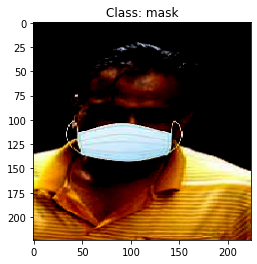

In [6]:
plt.imshow(X_train[77])
plt.title("Class: " + y_train[77])
plt.show()

In [7]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(y_train.reshape(-1,1))

y_train = ohe.transform(y_train.reshape(-1,1)).toarray()
y_val = ohe.transform(y_val.reshape(-1,1)).toarray()
y_test = ohe.transform(y_test.reshape(-1,1)).toarray()

In [8]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [9]:
X_train.shape

(1000, 224, 224, 3)

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [11]:
baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [15]:
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Epoch 1/10
10/31 [========>.....................] - ETA: 8s - loss: 0.7684 - accuracy: 0.6031

KeyboardInterrupt: 

In [ ]:
model.save("mask_detector.model", save_format="h5")

In [16]:
predIdxs = model.predict(X_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=("mask","no_mask")))

              precision    recall  f1-score   support

        mask       0.83      1.00      0.91        97
     no_mask       1.00      0.79      0.89        97

    accuracy                           0.90       194
   macro avg       0.91      0.90      0.90       194
weighted avg       0.91      0.90      0.90       194



In [17]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

NameError: name 'H' is not defined

<Figure size 432x288 with 0 Axes>

In [19]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [20]:
prototxtPath = os.path.sep.join(["deploy.prototxt.txt"])
weightsPath = os.path.sep.join(["res10_300x300_ssd_iter_140000.caffemodel"])

In [21]:
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [22]:
model = load_model("mask_detector.model")

In [28]:
image = cv2.imread("./data/train/no_mask/288.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


In [29]:
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.90:
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

-1